# Assessment Overview
***

On the [keras website](https://keras.io/), there is an example of [time-series anomaly detection](https://keras.io/examples/timeseries/timeseries_anomaly_detection/). Re-create this example in a notebook of your own, explaining the concepts.   

Clearly explain each Keras function used, referring to the documentation.   

Include an introduction to your notebook, setting the context and describing what the reader can expect as they read down through the notebook.   

Include a conclusion section where you suggest improvements you could make to the analysis in the notebook.

# Introduction
***

Keras is an Application Programming Interface (API) that can be used in Python to build deep learning models[<sup>1</sup>](#f1).<a id='a1'></a> Running on top of the machine learning library TensorFlow, Keras is designed to be a higher-level introduction to deep learning, with the goal of fast experimentation. This allows the user to focus more on the ideas and outcomes they wish their models to achieve without needing to focus as much on the underlying mathematics performed by TensorFlow.

The Keras website provides [examples](https://keras.io/examples/) for many deep learning tasks, such as the one that will be looked at in this notebook, ["Timeseries anomaly detection using an Autoencoder"](https://keras.io/examples/timeseries/timeseries_anomaly_detection/)[<sup>2</sup>](#f2).<a id='a2'></a> The goal of these examples appears to be to show the user what to do so the user can get started as quickly as possible. However, they provide little detail as to why and how the example code works. This notebook attempts to expand upon the example provided by Keras for Timeseries anomaly detection using an Autoencoder by discussing the purpose of the Keras functions they use and how those functions work, why they make the choices they do when it comes to model design, and suggest aspects of their design that might be improved upon. While most of the code comes from the example provided by Keras, there are some adaptions throughout that come from [here](https://github.com/ianmcloughlin/2223-S1-machine-learn-stats/blob/main/notebooks/05-evaluation.ipynb)[<sup>3</sup>](#f3).<a id='a3'></a>

In [1]:
# Numerical arrays.
import numpy as np

# Spreadsheet-like Data Frames.
import pandas as pd

# Neural networks.
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt

This is the code that imports the packages needed to run this code. Numpy is a package that allows for quick and easy manipulation of numerical arrays[<sup>4</sup>](#f4).<a id='a4'></a> Pandas is used to create data frames, which is used to work with data that is similar to a spreadsheet in excel[<sup>5</sup>](#f5).<a id='a5'></a> Keras is the package which is used for neural networks and deep learning models. Of note is that the example on the Keras website imports keras and tensorflow.keras.layers separately. This does make the code shorter when using layers functions, but with the drawback of it being less clear to anyone looking at the code where the layers functions come from. Instead, this notebook will use the longer code of calling keras.layers for clarity. Finally, matplotlib.pyplot is imported to plot data throughout the notebook[<sup>6</sup>](#f6).<a id='a6'></a>

## Data

***


The data used in this example comes from Numenta Anomaly Benchmark (NAB)[<sup>7</sup>](#f7).<a id='a7'></a> Their data is used to evaluate algorithms to detect anomalies in streaming data. More specifically, this notebook will use two datasets from NAB. The first dataset is art_daily_small_noise.csv, which is an artificial dataset that has some small amounts of noise and variation in data values, but does not contain any anomalous values. The file contains two columns of data. The first column contains a timestamp of the date and time the measurement was taken, and the second column contains the value measured at that time. Exactly what that value measures is not clear from looking at the data, nor is it important for the purposes of our task to detect anomalies. The second dataset is called art_daily_jumpsup.csv and is similar to the first dataset but with one important difference - somewhere among the data is a series of anomalous data values. The Keras example shows how we can use Keras functions and the dataset with no anomalies to train a model to learn what patterns of data values are considered normal at specific times. The model can then be tested to see if it can show where the anomalies are in the second dataset. 

In [2]:
# Root of URLs.
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'

# Data file without anomaly.
no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'

# Data file with anomaly.
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'

In [3]:
# Check that the url for the no anomaly csv file is concatonated correctly
no_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv'

In [4]:
# Check that the url for the with anomaly csv file is concatonated correctly
with_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv'

The code is hosted on the NAB GitHub page[<sup>8</sup>](#f8)<a id='a8'></a> and can be imported to python using the URLs of the CSV files that store the data. It's worth noting that the URLs are raw to get direct access to the CSV files. If we navigate through the repositories to the CSV files, the URL will end in .csv, for example, https://github.com/numenta/NAB/blob/master/data/artificialNoAnomaly/art_daily_small_noise.csv, but this URL cannot be used to import the CSV to python as it is actually an HTML link that renders the CSV file. Instead, we can click on the 'Raw' button at the HTML link to get the link that Python can use to import the CSV data. 

In [5]:
# Import the small noise no anomaly csv to a pandas dataframe
df_small_noise = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

Pandas can be used to read in the data from the CSV file into a format that Python can use. The parse_dates argument can be passed as True to ensure that the timestamps are read in correctly as dates and times. The timestamp column is also used as the index for the data frame. 

In [6]:
# Look at the first five entries of the no anomaly data
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [7]:
# View some summary statistics of the no anomaly data
df_small_noise.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


Since the dataset has thousands of values, it's not practical to manualy look at each entry to see if it's been read in correctly. What can be done instead is to look at the first five entries using the .head() Pandas function and use the .describe() Pandas function to get some summary statistics which can provide some useful information. We can compare these to the data held on github and see that by looking at the head, it appears that the values have been rounded when imported to pandas to six decimal places. We can also see that there are 4032 entries, which lines up with the CSV file, which has 4033, but it counts the headings as the first entry whereas Pandas doesn't. We can also visualise the data somewhat with this information. Half of the dataset falls between the minimum value of 18.000964 and the median of 21.608487. There is then a large difference between the median and the 75th percentile value of 75.450282 and the maximum value of 87.976128. This suggest a somewhat stable baseline value of ~20 for most values, and a less stable peak of ~80 for other values. 

In [8]:
# View information about the first entry of the no anomaly data
df_small_noise.iloc[0]

value    18.324919
Name: 2014-04-01 00:00:00, dtype: float64

In [9]:
# View the complete value of the first value imported as pandas seems to have rounded the values to 10 decimal places
df_small_noise.iloc[0]['value']

18.3249185392

In [10]:
# Confirming that the first value has been rounded. It was 18.324918539200002 in the original csv
df_small_noise.iloc[0].values[0]

18.3249185392

It's worth taking a closer look at the first value imported to see how it's been rounded by Pandas and whether that rounding is something which could be of concern for our model and analysis. Using .iloc[0] to get information about the first row in the dataframe shows the same value as when we looked at the head, but if we access only the value from the first row, it shows us that the value has more decimal places than initially appeared, but is still rounded from the original value of 18.324918539200002. This is due to a read_csv argument called float_precision, which is equal to None if it's not explicitly specified by the user. If we explicitly set float_precision='round_trip', then the values will not be rounded[<sup>9</sup>](#f9).<a id='a9'></a>

In [11]:
# Import the small noise no anomaly csv to a pandas dataframe without rounding values
df_small_noise2 = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp", float_precision='round_trip')

# Show that the value has now not been rounded by Pandas
df_small_noise2.iloc[0]['value']

18.324918539200002

Since the original Keras example proceeds with the rounded values this notebook will do the same, but it's worth highlighting that Pandas may round values since there may be other datasets where we would want the original values to be maintained without any rounding. 

In [12]:
# Confirming the shape of the output is what's expected
df_small_noise.shape

(4032, 1)

Checking the shape confirms that we have a one-dimensional set of values (as the timestamp is considered to be an index and not an extra column of data) which contains 4032 data points.

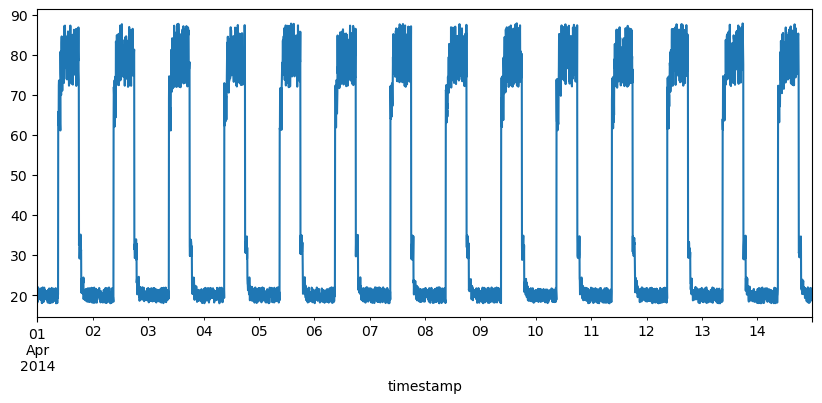

In [13]:
# Specify a size for the plot
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot the no anomaly data frame.
df_small_noise.plot(legend=False, ax=ax);

We can use PyPlot and Pandas to plot the data for us so we can easily visualise its contents. As suggested by the summary statistics, the data appears to fluctuate around a baseline of 20 before it spikes and has a larger fluctuation between ~73 and ~87. This is a pattern that repeats at regular intervals. Indeed, this plot makes it easy to see that there is a pattern to the data. While the values for each cycle are not identical every time, they are similar enough to suggest there is a narrow range of values that can be considered normal.

In [14]:
# Import the daily jumpsup with anomaly csv to a pandas dataframe
df_daily_jumpsup = pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

In [15]:
# Look at the first five entries of the with anomaly data
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


In [16]:
# View some summary statistics of the with anomaly data
df_daily_jumpsup.describe()

,value
count,4032.000000
mean,44.494254
std,32.432473
min,18.001010
25%,19.991382
50%,21.648503
75%,76.435943
max,164.947481


We can use the same process to import the data that we know contains an anomaly using Pandas. The head and description make the dataset look very similar to the no anomaly dataset, except for one major difference. The maximum value for the no anomaly dataset was 87.976128 but the maximum value for the dataset with anomalies is 164.947481 - nearly twice the value. This is enough to increase both the mean and standard deviation by a few points each. 

In [17]:
# View information about the first entry of the with anomaly data
df_daily_jumpsup.iloc[0]['value']

19.761251903

In [18]:
# Confirming the shape of the output is what's expected
df_daily_jumpsup.shape

(4032, 1)

Again we can see that the first value has been rounded, so at least we know that while the values are rounded, it has been done consistently across both datasets. The shape is also what we expect so between that, the head, and the descriptive statistics, we can feel confident that the CSV has been read in correctly. 

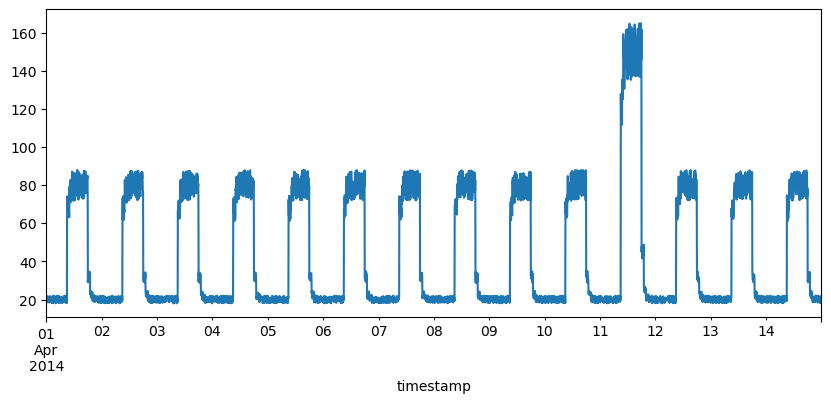

In [19]:
# Specify a size for the plot
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot the with anomaly data frame.
df_daily_jumpsup.plot(legend=False, ax=ax);

Viewing the plot of the with anomaly dataset makes it immediately obvious where the anomaly lies as there are a series of data points that tower far above all the others on the 11th of April. Apart from that, this dataset appears to follow a similar pattern to the no anomaly dataset with a similar baseline, peak, fluctuation, and regularity. 

## Preprocessing

***

Preprocessing is the process of preparing the data for analysis[<sup>10</sup>](#f10).<a id='a10'></a> This is the stage where the data is cleaned and transformed so that it is in the most appropriate condition for analysis. A preprocessing step not shown in the Keras example that might have been useful for this data set is checking whether there are any missing values in the imported data. Missing values may skew the results so it's good practise to check for and deal with any null values before analysis.

In [20]:
# Add up any missing values in the no anomaly dataframe
df_small_noise.isna().sum()

value    0
dtype: int64

In [21]:
# Add up any missing values in the no anomaly dataframe
df_daily_jumpsup.isna().sum()

value    0
dtype: int64

Both the no anomaly and with anomaly dataframes appear to have no missing values. The main preprocessing step done in the Keras example is standardization[<sup>11</sup>](#f11).<a id='a11'></a> This is performed on the no anomaly dataset in order to prepare it for training our model. Standardization involves calculating the mean and standard deviation of the dataset. The mean is then subtracted from the data value, and this is in turn divided by the standard deviation. This is done for all the values in the dataset. Standardization results in all the data having a mean of zero and a standard deviation of one, and is done to scale the data in such a way that increases the accuracy of machine learning models.

In [22]:
# Getting the mean of the values in the no anomaly data
train_mean = df_small_noise.mean()

train_mean

value    42.438353
dtype: float64

In [23]:
# Getting the standard deviation of the values in the no anomaly data
train_std = df_small_noise.std()

train_std

value    28.077122
dtype: float64

In [24]:
# Standardising the values
df_train_vals = (df_small_noise - train_mean) / train_std

In [25]:
# Look at the first five entries of the standardised no anomaly data
df_train_vals.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


In [26]:
# Add a column to the original no anomaly dataframe with the values of the datapoint minus the mean
df_small_noise['less_mean'] = df_small_noise['value'] - df_small_noise['value'].mean()

# Add a column to the original no anomaly dataframe with standardised values
df_small_noise['div_std'] = df_small_noise['less_mean'] / df_small_noise['value'].std()

# Show the no anomoly dataframe with the two newly added columns
df_small_noise

,value,less_mean,div_std
timestamp,,,
2014-04-01 00:00:00,18.324919,-24.113435,-0.858829
2014-04-01 00:05:00,21.970327,-20.468026,-0.728993
2014-04-01 00:10:00,18.624806,-23.813547,-0.848148
2014-04-01 00:15:00,21.953684,-20.484669,-0.729586
2014-04-01 00:20:00,21.909120,-20.529234,-0.731173
...,...,...,...
2014-04-14 23:35:00,20.211195,-22.227159,-0.791647
2014-04-14 23:40:00,20.531041,-21.907313,-0.780255
2014-04-14 23:45:00,19.032127,-23.406226,-0.833640


We can compare the new standardized values to the old values and see that the numbers are now much smaller and closer together. However, the printout above only seems to show how values around the baseline of 20 have changed to values around -0.8. We know from our earlier plot of the dataset that there are also values closer to 80, so it might be useful to also see how these values have changed. 

In [27]:
df_small_noise.iloc[150:155]

,value,less_mean,div_std
timestamp,,,
2014-04-01 12:30:00,82.815569,40.377216,1.438082
2014-04-01 12:35:00,76.951378,34.513025,1.229222
2014-04-01 12:40:00,74.042401,31.604048,1.125616
2014-04-01 12:45:00,82.019798,39.581445,1.409740
2014-04-01 12:50:00,73.964350,31.525997,1.122836


The above output shows that the larger values are now between 1 and 1.5. 

In [28]:
# View the mean of the three columns in the no anomaly data 
df_small_noise['value'].mean(), df_small_noise['less_mean'].mean(), df_small_noise['div_std'].mean()

(42.438353335806646, -7.342627387941552e-14, -2.616541242931684e-15)

This output shows that the less mean column and the div std column are very close to zero, which is what we are looking for when standardizing the data. 

In [29]:
# View the standard deviation of the three columns in the no anomaly data
df_small_noise['value'].std(), df_small_noise['less_mean'].std(), df_small_noise['div_std'].std()

(28.077122281262515, 28.077122281262508, 1.0000000000000018)

Again, this confirms that the data is standardised, with the standard deviation of the first two columns being almost identical, while the standard deviation of the last column is close to 1. 

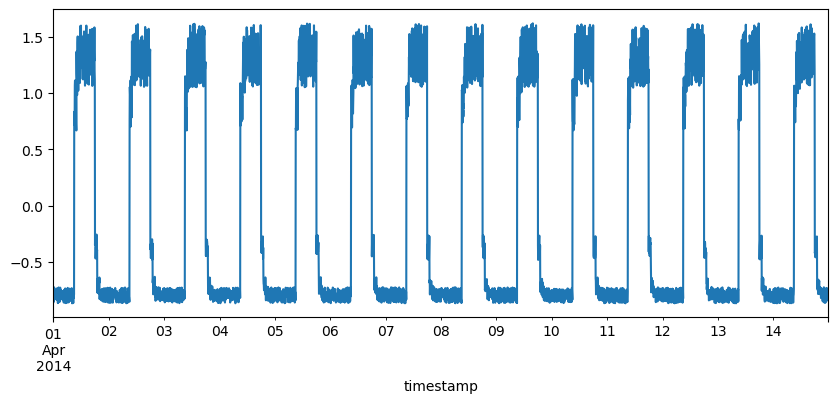

In [30]:
# Specify a size for the plot
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot the standardised no anomaly data frame.
df_train_vals.plot(legend=False, ax=ax);

The plot of the standardized no anomaly data should look almost identical to the non-standardized no anomaly data, with the exception of the scale being altered. This is shown on the y-axis, with all values now falling between ~-0.8 and 1.6.

In [31]:
# Confirming that the shape of the standardised no anomaly data is what we expect
df_train_vals.shape

(4032, 1)

The shape of the data should also be unchanged, containing the same number of data points and dimensions.

In [32]:
# Specifying the size for the windows
window_size = 288

Another step for preprocessing is dividing the data into smaller sizes for the purposes of training[<sup>12</sup>](#f12).<a id='a12'></a> The smaller windows of data should be the same size to allow the model to be consistent when processing each window of data. The Keras example chooses a window size of 288. They don't say why this number is chosen, but it may be so that every data window contains "1 day" of data. The values in the dataset are recorded in 5-minute intervals, and 288x5=1440 minutes, or 1440/60=24 hours. Since the dataset is quite large, a toy example can be used to better understand the concept of windows.

Window example:

```python
[1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]
window_size = 3
[1, 1, 2]
[1, 2, 4]
[2, 4, 5]
[4, 5, 6]
...
```

The above shows an array as well as the first 4 windows with a size of 3 that we can make from that array. The first window contains the first 3 values of the array, the second window starts from the second value and contains the 3 values from that position, the third window starts from the third number, and so on.

In [33]:
# Window list example.
L = [1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]
# Example window size.
win_size = 3
# Length of L.
len(L)

12

In [34]:
# Number of windows from L.
len(L) - (win_size - 1)

10

In [35]:
# Remove brackets.
len(L) - win_size + 1

10

It should be noted that while the initial array has 12 numbers, there will only be 10 windows made. This is because the 10th entry in the array is the last number that can make a window containing 3 numbers which consists of the 10th, 11th, and 12th numbers. The next window would start at the 11th number, but since the only number following it is the 12th, there is no third number to complete that window. 

In [36]:
# Print the windows.
for i in range(len(L) - win_size + 1):
    print(L[i:i + win_size])

[1, 1, 2]
[1, 2, 4]
[2, 4, 5]
[4, 5, 6]
[5, 6, 7]
[6, 7, 1]
[7, 1, 2]
[1, 2, 3]
[2, 3, 4]
[3, 4, 5]


The above print out shows all 10 windows that can be made from our initial toy array of 12 values. 

In [37]:
# For accumulating the windows.
wins = []

# Generate the windows
for i in range(len(L) - win_size + 1):
    wins.append(L[i:i + win_size])

wins

[[1, 1, 2],
 [1, 2, 4],
 [2, 4, 5],
 [4, 5, 6],
 [5, 6, 7],
 [6, 7, 1],
 [7, 1, 2],
 [1, 2, 3],
 [2, 3, 4],
 [3, 4, 5]]

The above for loop shows how we can then append each of this windows to a list.

In [38]:
# Create a 2D numpy array from wins.
np.stack(wins)

array([[1, 1, 2],
       [1, 2, 4],
       [2, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 1],
       [7, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5]])

These lists can then be made into a two dimensional numpy array, which is what will be used to train our model.

In [39]:
# Function to return windowed values of the input data
def windows(vals, N=window_size):
  # Create an empty list to append the windowed data to
  L = []
  # Iterate over the inpuit data for the length of the specified window
  for i in range(len(vals) - N + 1):
    # Append the input data which is the same length as the specified window
    L.append(vals[i:i+N])
  # Stack windows into an array
  return np.stack(L)

The above code shows how the Keras example takes the concepts outlined in our toy window example to create a function that can be used to divide the no anomaly data into equal sized windows for the purposes of training. 

In [40]:
# Use the windows function on the standardised no anomaly data
x_train = windows(df_train_vals)

In [41]:
# View the standardised no anomaly data which is now divided into windows
x_train

array([[[-0.85882857],
        [-0.72899302],
        [-0.84814772],
        ...,
        [-0.86453747],
        [-0.81250829],
        [-0.79671155]],

       [[-0.72899302],
        [-0.84814772],
        [-0.72958579],
        ...,
        [-0.81250829],
        [-0.79671155],
        [-0.78767946]],

       [[-0.84814772],
        [-0.72958579],
        [-0.731173  ],
        ...,
        [-0.79671155],
        [-0.78767946],
        [-0.73706287]],

       ...,

       [[-0.8226548 ],
        [-0.86660975],
        [-0.82181363],
        ...,
        [-0.79164661],
        [-0.78025492],
        [-0.83364049]],

       [[-0.86660975],
        [-0.82181363],
        [-0.75595835],
        ...,
        [-0.78025492],
        [-0.83364049],
        [-0.73510213]],

       [[-0.82181363],
        [-0.75595835],
        [-0.74256753],
        ...,
        [-0.83364049],
        [-0.73510213],
        [-0.8460886 ]]])

In [42]:
# Check the first and last entry
x_train[0][0], x_train[-1][-1]

(array([-0.85882857]), array([-0.8460886]))

In [43]:
# Extra detail about the first and last entry
df_train_vals.iloc[0], df_train_vals.iloc[-1]

(value   -0.858829
 Name: 2014-04-01 00:00:00, dtype: float64,
 value   -0.846089
 Name: 2014-04-14 23:55:00, dtype: float64)

The above outputs confirm that the data is now in windows and added to an array. We can compare the first and last entries in the training array too and confirm that they are the same as the first and last values in the standardised no anomaly dataframe.

In [44]:
# Confirming the shape of the windowed no anomaly data
x_train.shape

(3745, 288, 1)

We can see now that the data has an additional dimension, as it contains 3745 entries that each contain 288 values. As explained above, the 3745 entries is fewer than our initial data size of 4032 because there will be entries that wont have enough values after them to be able to make a window of 288. 

In [45]:
# Check some of the original standardized no anomaly data to see if they match the windowed data
df_train_vals['value'].values

array([-0.85882857, -0.72899302, -0.84814772, ..., -0.83364049,
       -0.73510213, -0.8460886 ])

In [46]:
# Flatten and view the data points in the first window 
x_train[0].flatten()

array([-0.85882857, -0.72899302, -0.84814772, -0.72958579, -0.731173  ,
       -0.75730984, -0.77645641, -0.7880838 , -0.747012  , -0.829166  ,
       -0.80377285, -0.7821597 , -0.81182078, -0.80949918, -0.82334701,
       -0.79001779, -0.74922405, -0.84169024, -0.73727717, -0.77223023,
       -0.75311352, -0.79116337, -0.75934728, -0.86809294, -0.75381057,
       -0.86468256, -0.74361965, -0.72908121, -0.82850668, -0.84043795,
       -0.76136364, -0.8343536 , -0.74708881, -0.85574949, -0.85245676,
       -0.73090636, -0.77440264, -0.74974936, -0.82419543, -0.77402585,
       -0.78574242, -0.7844733 , -0.77316412, -0.78843253, -0.80927467,
       -0.83109167, -0.76090519, -0.83816509, -0.77176485, -0.83715923,
       -0.78131343, -0.76396862, -0.83924191, -0.86186112, -0.85174179,
       -0.78406773, -0.74938477, -0.86399047, -0.76581026, -0.82177506,
       -0.80222751, -0.73807119, -0.82310669, -0.80410682, -0.86845167,
       -0.85877599, -0.83356075, -0.86643297, -0.78045221, -0.80

We can use flatten to have a look at all the values within a window. The above printout shows all the values within the first window.

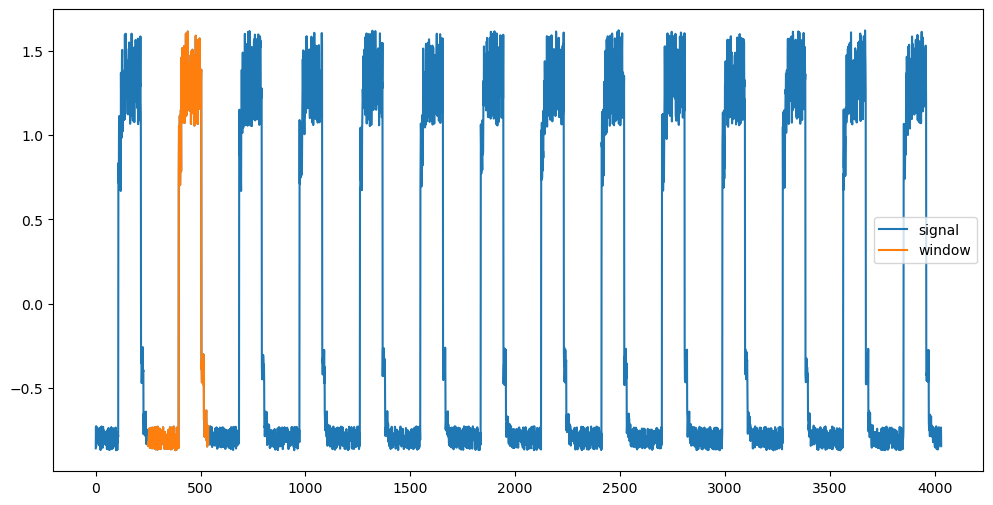

In [47]:
# Select the 250th window
window_no = 250

# Specify a size for the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Get the standardised no anomaly data
y = df_train_vals['value'].values

# Plot the standardised no anomaly data
ax.plot(np.arange(y.shape[0]), y, label='signal')

# Get the values contained in the window number specified earlier
# Flattened to be able to plot them
w = x_train[window_no].flatten()

# Plot the data from the window specified on top of the standardised no anomaly plot 
ax.plot(np.arange(w.shape[0]) + window_no, w, label='window')
ax.legend();

Since we can access all the values within a window using flatten, we can take advantage of this to further visualise a window of data by plotting the values of a window on top of the standardised no anomaly data. The plot above shows where the values of the 250th window fall in relation to the overall data set by highlighting the window in orange. 

## Neural Network

***

This is the step where a neural network model is built. As stated in the Keras example, "We will build a convolutional reconstruction autoencoder model". Since that's quite a jargon heavy sentence, it's worth taking a moment to further define and explain some of those terms before getting into the code. 

A convolution is a mathematical concept that takes two functions (e.g. f and g) and produces a third function which shows how much f affects g as f is shifted over g. The operation ""blends" one function with another"[<sup>13</sup>](#f13).<a id='a13'></a> This concept can be used in neural networks, where a "convolutional layer" has a filter that shifts over the input data, and the result is a feature map that can allow the model to learn important features and patterns from the input data[<sup>14</sup>](#f14).<a id='a14'></a>   

An autoencoder is a model that first encodes the input data by reducing the representation of the input data, and then decodes this reduced representation in order to try reconstruct the data again[<sup>15</sup>](#f15).<a id='a15'></a> The reconstructed data is then compared to the input data. Doing this allows the model to learn the most important features of the data unsupervised. 

A "convolutional reconstruction autoencoder model" is a model where convolutional layers are used to parse out the most important features of data, and use this information to try recreate what the data should be. This is useful for time series anomaly detection since, if the model is tuned accurately, it should be able to deduce the expected values at particular times, and any values that veer too far from these expected values can be flagged as anomalous.

Using Keras, we can define the number of convolutional layers and filters we wish to apply to our data set. The Keras example uses eight layers as shown below. The Keras example does not provide any information about why they use eight layers, nor why they chose the number of filters or kernel sizes they do. These features are known as hyperparameters and they are usually determined either because of the coder's background knowledge and/or through trial and error[<sup>16</sup>](#f16).<a id='a16'></a> Another option is by using KerasTuner, which is a Keras package which allows the user to to specify multiple possible hyperparameters and KerasTuner provides feedback about model performance based on the provided hyperparameters[<sup>17</sup>](#f17).<a id='a17'></a> A separate Keras webpage also suggests that instead of adding all the layers at once, layers can be added using the add() function which allows the user to use model.summary() after adding each layer. This extra information can be useful deciding hyperparameter values[<sup>18</sup>](#f18).<a id='a18'></a>

In [48]:
# Defining the layers for the model
layers = [
  # Shape of the input
  keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
  # Apply 1d convolutional filters 
  keras.layers.Conv1D(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  # Define the dropout rate to prevent overfitting
  keras.layers.Dropout(rate=0.2),
  # Apply 1d convolutional filters
  keras.layers.Conv1D(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  # Apply transposed 1D convolution/deconvolution
  keras.layers.Conv1DTranspose(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  # Define the dropout rate to prevent overfitting
  keras.layers.Dropout(rate=0.2),
  # Apply transposed 1D convolution/deconvolution
  keras.layers.Conv1DTranspose(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  # Apply transposed 1D convolution/deconvolution
  keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
]

The first layer is keras.layers.Input, which provides the shape of the data, which is taken from the x_train input dataset. The first value is 288 for the size of each window and the second value is 1, which represents the 1 dimension of values held within each window. 

The second layer is keras.layers.Conv1D, which is a one dimensional convilutional layer. This layer will have 32 filters, and the kernel size equalling 7 means that the filters will compute 7 input values at a time. Padding = "same" means the output will be surrounded by zeros to give the output the same dimensions as the input. The stride equalling 2 means that the filter will move 2 values each time, meaning some values will be skipped. This can be used to increase the speed of the processing, or to reduce the size of the output values to prevent the model becoming overly complex. Setting activation="relu" means that the rectified linear unit (ReLU) activation function is used to define the output of a neuron and introduce non-linearity. ReLU is a popular choice due to its computational simplicity, while performing better than other activation functions in many cases[<sup>19</sup>](#f19).<a id='a19'></a> 

The third layer is keras.layers.Dropout, which sets a specified amount, in this case 20%, of input units to 0. This is done to prevent overfitting, which is where the model becomes too tuned to the input data, which can negatively impact performance for the model when using different data. 

The fourth layer is another keras.layers.Conv1D convilutional layer, but this time with fewer filters to reduce the dimensonality compared with the initial layer. 

The fifth layer is keras.layers.Conv1DTranspose, which tries to recreate the data that has been encoded by the earlier keras.layers.Conv1D layer and takes the same arguments. This can also be called deconvolution, which is the inverse of convolution. 

The sixth layer is an additional dropout layer, which works the same as the earlier dropout layer by changing a fraction of inputs to 0. 

The seventh layer is another keras.layers.Conv1DTranspose, which tries to recreate the data that was encoded by the first Conv1D layer.

The eighth and final layer is a keras.layers.Conv1DTranspose, but this time has only one filter and no activation function as it tries to return an output the same shape as the input data. 

In [49]:
# Add the layers to sequential model
model = keras.Sequential(layers)

The model can be created by passing the specified layers to keras.Sequential, which creates a sequential model. This is a model which groups the layers into a linear stack.

In [50]:
# Specify the optimization algorithm to use during training
optimizer = keras.optimizers.Adam(learning_rate=0.001)

An optimizer is used for stochastic gradient descent optimization[<sup>20</sup>](#f20).<a id='a20'></a> It is an algorithm that updates the value of the weights based on the based on the gradient descent of the loss function in relation to the weights. The change in weight is done to try minimise the loss function and in turn increase the model's accuracy. Keras has a selection of optimizers that can be used, but the example goes with the Adam optimizer, which is popular due to its low memory usage and high efficiency[<sup>21</sup>](#f21).<a id='a21'></a> The learning rate is the value which determines how much the weights are changed during each step of the optimization process. If the learning rate is too high, this could result in overshooting which is when the weights are adjusted too much and the optimal solution is missed. If the learning rate is too low, then it may take a long time for the weights to converge with the optimal solution. A learning rate of 0.001 is considered to be a good starting point and is recommended by Keras as the default learning rate for Adam. 

In [51]:
# Compile the model for training
model.compile(optimizer=optimizer, loss="mse")

The optimizer works with a loss function in order to train the model through the use of the compile function. A loss function calculates the difference between the predicted output and the target output. For each epoch of training, the optimizer works to try decrease this value as much as possible. The loss function chosen for the Keras example is mean squared error (MSE), which gives the average square of the differences between the predicted output and the target output. MSE is a popular loss function since squaring the differences means that the larger the difference is, the more heavily the model is penalised[<sup>22</sup>](#f22).<a id='a22'></a>

In [52]:
# Provide a summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 144, 16)           1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 288, 1)            2

The summary function provides details about the model we've created. As well as showing us the layers we've created and the shape of the layer's outputs, we get told the number of parameters, which are the values that get updated during the training process. Knowing this can give the user an idea of how complex their neural network is. Having too many parameters may also lead to overfitting, and not enough may lead to underfitting[<sup>23</sup>](#f23).<a id='a23'></a> 

In [53]:
# Train the model
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 1s 54ms/step - loss: 0.4772 - val_loss: 0.0561
Epoch 2/50
27/27 [==============================] - 1s 42ms/step - loss: 0.0718 - val_loss: 0.0383
Epoch 3/50
27/27 [==============================] - 1s 36ms/step - loss: 0.0539 - val_loss: 0.0341
Epoch 4/50
27/27 [==============================] - 1s 46ms/step - loss: 0.0469 - val_loss: 0.0293
Epoch 5/50
27/27 [==============================] - 1s 52ms/step - loss: 0.0417 - val_loss: 0.0267
Epoch 6/50
27/27 [==============================] - 1s 42ms/step - loss: 0.0375 - val_loss: 0.0242
Epoch 7/50
27/27 [==============================] - 1s 44ms/step - loss: 0.0342 - val_loss: 0.0221
Epoch 8/50
27/27 [==============================] - 1s 37ms/step - loss: 0.0315 - val_loss: 0.0209
Epoch 9/50
27/27 [==============================] - 1s 38ms/step - loss: 0.0295 - val_loss: 0.0201
Epoch 10/50
27/27 [==============================] - 1s 38ms/step - loss: 0.0278 - val_loss: 0.0195
Epoch 11/

model.fit is the function that trains the model, and it is stored in a variable history as Keras creates a history object that stores information about training performance such as the loss values. The first two arguments passed to the fit function are the input data and the data we want the model's output to be compared to. Since we want our model to try and encode and then recreate the input data, the same data set is used for both which is the windowed no anomaly data. 

An epoch is one pass through the entire training data, so setting it to 50 means the data should be iterated over by the model in full 50 times. The batch size is the number of samples that get updated throughout the network. In this case, the first 128 values are trained and updated, then values 129-256 are passed, and this is repeated until all available samples have been trained. This completes 1 epoch. Passing the data through in batches is preferred as it is less memory intensive and makes the model more generalizable[<sup>24</sup>](#f24).<a id='a24'></a>

The validation split variable sets aside a fraction of the input data to use for validation purposes at the end of each epoch and will not be trained on. This is another value that has to be decided based on either experience and/or trial and error. The split should be high enough for the validation data to be useful, but not so high that the data left for training is insufficient and leads to an underperforming model. 

Adding keras.callbacks.EarlyStopping will stop the training early if there isn't enough change in performance from epoch to epoch. In this instance, if the validation loss doesn't decrease for 5 epochs, then the training will stop. This is useful to prevent overfitting and to speed up training as it would be wasteful of both time and computing resources to continue training when no further improvement is occurring. 

## Evaluation

***

We can now evaluate the model to check how well it performs. If the model is trained as we expect, then we should see that the training loss and validation loss have both decreased over time and converged to similar values. The values for both training loss and validation loss for all completed epochs can be accessed from the history object that was created during model training

In [54]:
# Show the loss values for each epoch
history.history["loss"]

[0.47722098231315613,
 0.071824811398983,
 0.05394356697797775,
 0.04692952707409859,
 0.04165934771299362,
 0.03750595822930336,
 0.034168727695941925,
 0.03153495490550995,
 0.029526883736252785,
 0.027779174968600273,
 0.026264993473887444,
 0.025190414860844612,
 0.024050196632742882,
 0.023082740604877472,
 0.02217814140021801,
 0.02126666158437729,
 0.02039559744298458,
 0.019626542925834656,
 0.01899665966629982]

In [55]:
# Show the validation loss value for each epoch
history.history["val_loss"]

[0.056117910891771317,
 0.038259003311395645,
 0.03412553295493126,
 0.02925902232527733,
 0.026735881343483925,
 0.024193506687879562,
 0.022075960412621498,
 0.02085631527006626,
 0.02009422518312931,
 0.0195431187748909,
 0.019801370799541473,
 0.018745463341474533,
 0.01888032630085945,
 0.017737656831741333,
 0.01858924701809883,
 0.018178459256887436,
 0.01975768245756626,
 0.018321795389056206,
 0.01871953345835209]

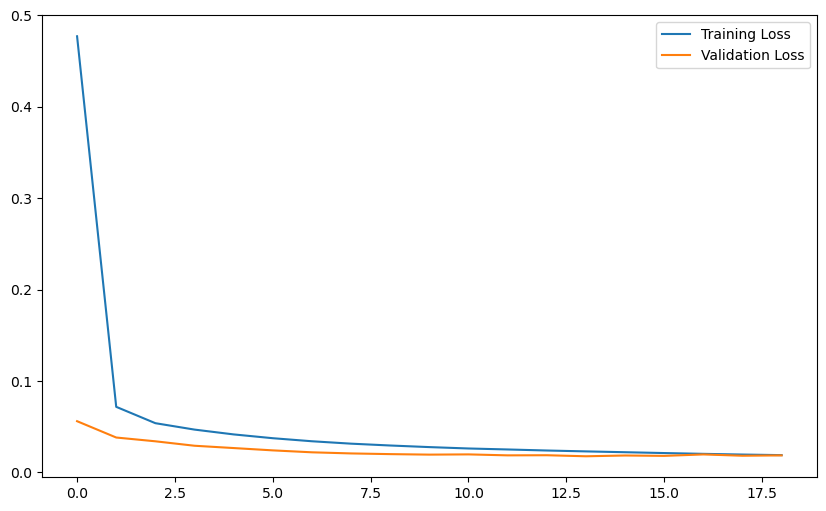

In [56]:
# Specify a size for the plot
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the training loss values
ax.plot(history.history["loss"], label="Training Loss")
# Plot the validation loss values
ax.plot(history.history["val_loss"], label="Validation Loss")
# Add legend to plot
ax.legend();

We can see from plotting the values that training loss and validation loss have converged over time

In [57]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)

We can now use our model to try and encode and recreate the no anomaly data.

In [58]:
# Calculate loss...
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

This code calculates the mean absolute error loss difference between the no anomaly data and the recreation of the no anomaly data from the model.

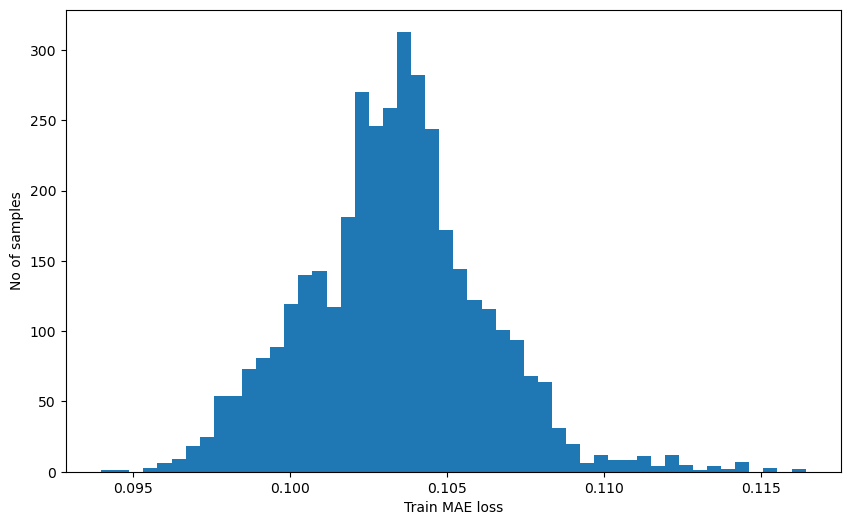

In [59]:
# Specify a size for the plot
fig, ax = plt.subplots(figsize=(10, 6))
# Plot a histogram of MAE values
ax.hist(train_mae_loss, bins=50)
# Label for x-axis
ax.set_xlabel("Train MAE loss")
# Label for y-axis
ax.set_ylabel("No of samples");

Plotting the MAE values shows that it follows something like a normal distribution, with the highest number of values in the middle and values decreasing as we move further away from the middle. The extremes have a tiny number of values. 

In [60]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)

# Show threshold value
threshold

0.11642067710698283

A commonly accepted method to detect time series anomalies is to take the largest MAE value that results from the training data and predicted data [<sup>25</sup>](#f25).<a id='a25'></a> This can be thought of as the most extreme value that the model would consider to be normal. If we input data to the model and it has datapoints that have a MAE greater than the threshold value, we can have these values highlighted ass anomalous. 

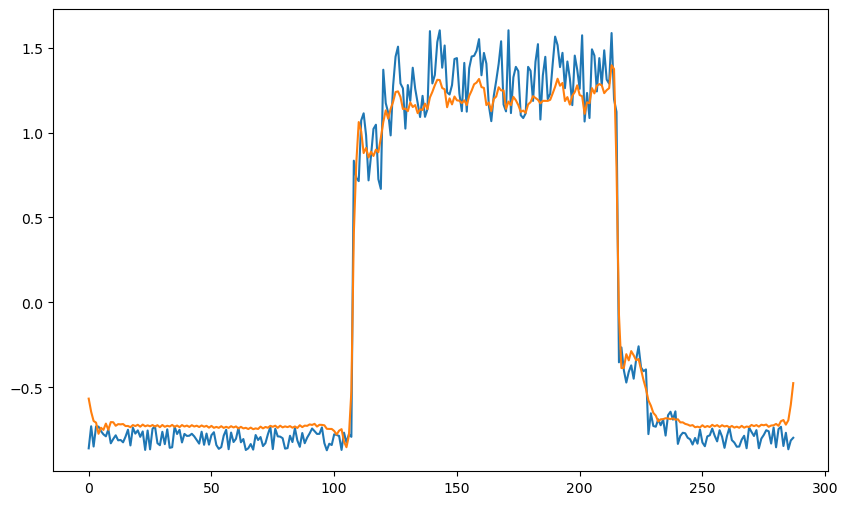

In [61]:
# Specify a size for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the first window of the training data
ax.plot(x_train[0])

# Plot the first window of the predicted data
ax.plot(x_train_pred[0]);

The Keras example adds this plot as another method of comparing the first window of input data (blue) to the predicted data (orange). We can see that the lines generally follow a similar pattern without completely overlapping, which suggests the model does a decent job at recreating the data without overfitting.  

In [62]:
# Standardise the test data which is the with anomaly dataset 
df_test_value = (df_daily_jumpsup - train_mean) / train_std

Now it's time to test our model using the with anomaly dataset. Like with the original data, the with anomaly data should be standardised. Note that it's standardised using the mean and standard deviations of the original no anomaly data, not the mean and standard deviation of the with anomaly data. This is to ensure that scaling is consistent between the training data and the test data[<sup>26</sup>](#f26).<a id='a26'></a>

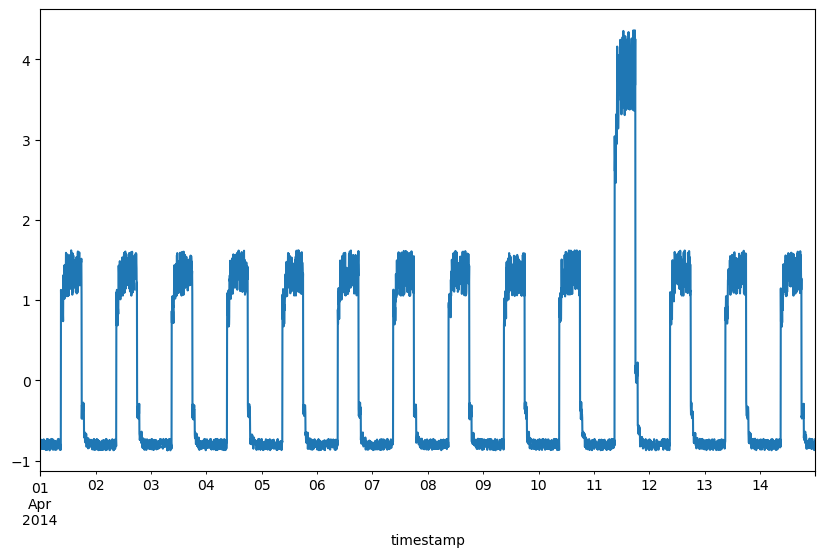

In [63]:
# Specify a size for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the standardised test data
df_test_value.plot(legend=False, ax=ax);

The standardised with anomaly data is plotted, and we can still visually see where the anomaly is, with the highest values reaching the standardised scale value of ~4, which is twice as high as any other cycle.

In [64]:
# Create sequences from test values.
x_test = windows(df_test_value.values)

# Show shape of test sequences
x_test.shape

(3745, 288, 1)

Like with the test data, the with anomaly training data should be divided into windows of 288 values each. The same function that was used with the no anomaly test data can be reused for this purpose. 

In [65]:
# Use the model to reconstruct the test data to calculate MAE loss
x_test_pred = model.predict(x_test)

We can now use our model to predict the values for the windowed and standardised with anomaly data. 

In [66]:
# Calculate test MAE loss
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

# View test MAE loss
test_mae_loss

array([[0.09745292],
       [0.10460286],
       [0.1034964 ],
       ...,
       [0.10237816],
       [0.10313993],
       [0.10165008]])

As with the test data, we can now calculate the MAE between the input test values and the output values predicted by the model. 

In [67]:
# Reshape test MAE loss to a 1d array
test_mae_loss = test_mae_loss.reshape((-1))

# View reshaped test MAE loss
test_mae_loss

array([0.09745292, 0.10460286, 0.1034964 , ..., 0.10237816, 0.10313993,
       0.10165008])

If we reshape the output MAE values, we can plot them to see how the MAE values look.

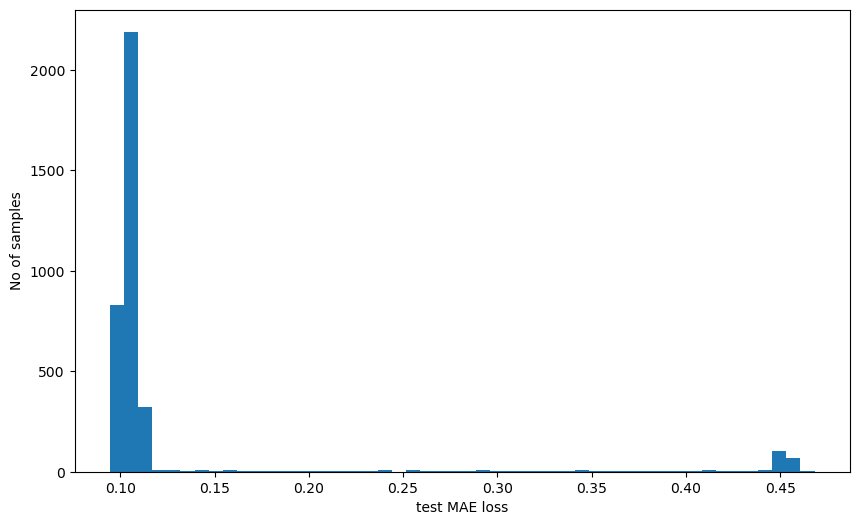

In [68]:
# Specify a size for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot a histogram of the test MAE loss
ax.hist(test_mae_loss, bins=50)

# Set x-axis label
ax.set_xlabel("test MAE loss")

# Set y-axis label
ax.set_ylabel("No of samples");

This plot shows that the anomalous data appears to have affected the MAE loss values, as there is a cluster of values near ~0.57 on the x-axis that are quite a large relative distance away from the vast majority of values. 

In [69]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold

# Number of anomalies.
np.sum(anomalies)

404

The anomalies can be isolated by simply comparing the MAE loss values of the test data to the threshold, and any values greater than the threshold get flagged as an anomaly. We can use np.sum to calculate the exact total of anomalous values that the model detected in the dataset. The variable anomalies contains a list of truth values. If the value is not an anomaly, it is False, or if it is an anomaly the value is True.

In [70]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
inds = []

for i in range(window_size - 1, len(df_test_value) - window_size + 1):
    if np.all(anomalies[i - window_size + 1 : i]):
        inds.append(i)

The code above uses the anomaly list of truth values to iterate over the windows of the with anomaly dataset, and will flag the index location that has multiple continuous anomalies. This is likely because we don't necessarily want to flag one or two individual points that may have been flagged as anomalies by chance. Rather, we want to detect a sequence of anomalous values that are more likely to correspond to an actual anomalous event. 

In [71]:
# Get the data from the locations that were detected to be anomalies from the with anomaly data
df_subset = df_daily_jumpsup.iloc[inds]

This code creates a new dataframe that consists only of the data values from the with anomaly dataset that have been flagged as anomalous in a sequence by the for loop above. We can then plot this dataframe subset to see if it overlaps with the extreme data values that appeared anomalous when plotted earlier. 

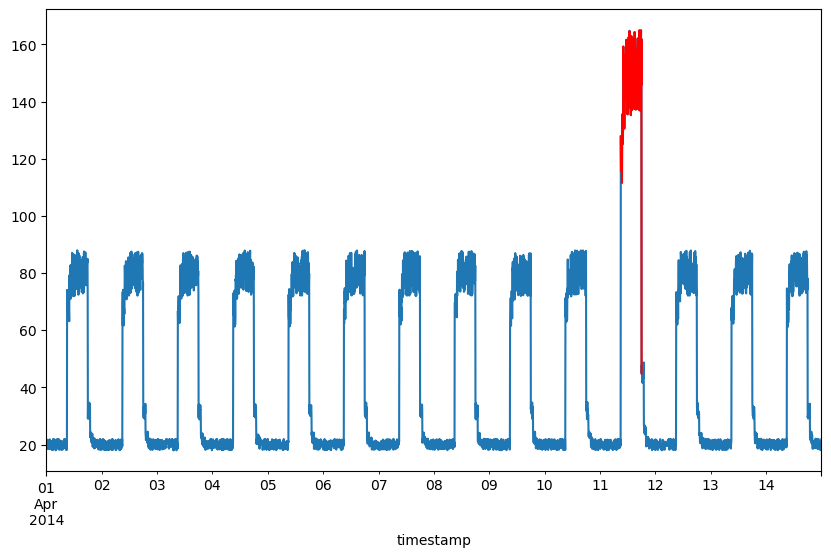

In [72]:
#Specify a size for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the with anomaly data
df_daily_jumpsup.plot(legend=False, ax=ax)

# Plot the data flagged as anomalous by the model
df_subset.plot(legend=False, ax=ax, color="r");

The above plot overlays the datapoints flagged as anomalous in red over the entire with anomaly dataset, and shows that the model did an impressive job in detecting the anomalous data. This should give us some confidence in the model's ability to generalise for other time series data that may also have anomalies.

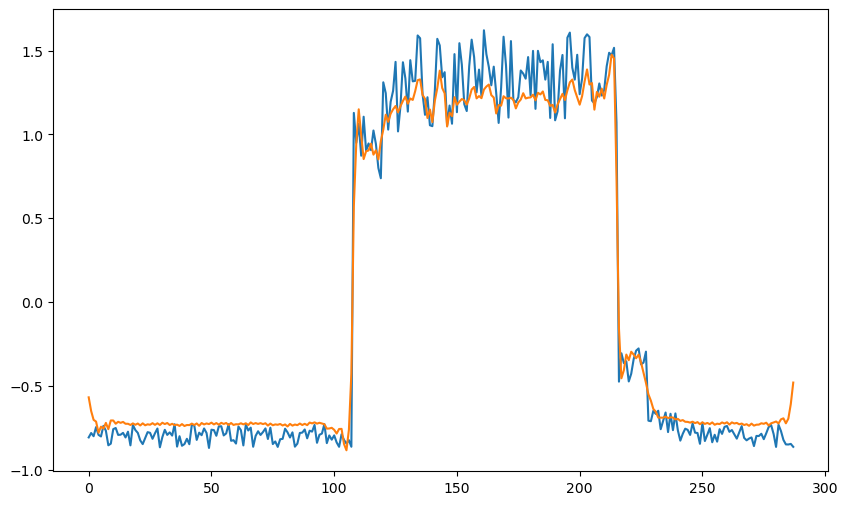

In [73]:
# Specify a size for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the first window of the test data
ax.plot(x_test[0])

# Plot the first window of the test data
ax.plot(x_test_pred[0]);

Finally, this plot was not included in the Keras example, but I thought it would be interesting to see how how model performed on the test data. As with the training data example earlier, this plot shows the first window of the with anomaly data and the model's predicted values. We can again see that the model shows a good performance in predicting the values for the first window. 

## Conclusion

***

Deep learning can be a useful tool for learning features about data, such as when data might contain anomalies. One way this can be done is through the use of the Keras package to train an autoencoder to try recreate expected data, and should the actual data fall outside a threshold of what the model thinks the data should be, it can be flagged as an anomaly. The most important takeaway is, simply, it works. We saw in this notebook how an autoencoder can be trained to detect anomalous datapoints in a time series. 

The example provided by Keras provides an easy entry point to building models of your own. However, it's strength is also its weakness - it's very direct and straight to the point. This allows us to quickly use their code, but provides no information about why were doing what we're doing and how we might need to adjust things for a different model and different data. Hyperparameters feed throughout to the model are vital for model performance, yet we have no idea how the Keras code arrives at the hyperparameters they do. Hyperparameters take trial and error to calibrate, although packages like KerasTuner might help. Another potential drawback is that an Autoencoder model may have a higher computation time than non-deep learning models due to the time needed to train the model[<sup>27</sup>](#f27).<a id='a27'></a> If this isn't a concern, however, autoencoders provide a good model for detecting anomalies in time series data.

# References
***

**1**.<a id='f1'></a> Keras. [online] https://keras.io [Accessed 06 January 2023].[↩](#a1)        
**2**.<a id='f2'></a> pavithrasv, 2020. Timeseries anomaly detection using an Autoencoder. [online] Available at: <https://keras.io/examples/timeseries/timeseries_anomaly_detection/> [Accessed 06 January 2023].[↩](#a2)      
**3**.<a id='f3'></a> McLoughlin, I., 2022. 05-evaluation.ipynb. [online] Available at: <https://github.com/ianmcloughlin/2223-S1-machine-learn-stats/blob/main/notebooks/05-evaluation.ipynb> [Accessed 06 January 2023].[↩](#a3)       
**4**.<a id='f4'></a> Numpy. [online]. Available at: <https://numpy.org/> [Accessed 06 January 2023].[↩](#a4)        
**5**.<a id='f5'></a> Pandas. [online] Available at: <https://pandas.pydata.org/> [Accessed 06 January 2023].[↩](#a5)     
**6**.<a id='f6'></a> Matplotlib. [online]. Available at: < https://matplotlib.org/>[Accessed 06 January 2023].[↩](#a6)      
**7**.<a id='f7'></a> BoltzmannBrain. 2017. Numenta Anomaly Benchmark (NAB). [online]. Available at: <https://www.kaggle.com/datasets/boltzmannbrain/nab>[Accessed 06 January 2023]. [↩](#a7)      
**8**.<a id='f8'></a> Numenta, 2022. The Numenta Anomaly Benchmark (NAB) GitHub Repository. [online]. Available at: <https://github.com/numenta/NAB> [Accessed 06 January 2023]. [↩](#a8)      
**9**.<a id='f9'></a> Livingstone,P., 2017. Pandas read csv file with float values results in weird rounding and decimal digits. [online] Available at: <https://stackoverflow.com/a/47368368>[Accessed 06 January 2023].[↩](#a9)     
**10**.<a id='f10'></a> Java Point. 2021. Data Preprocessing in Machine learning. [online]. Available at: <https://www.javatpoint.com/data-preprocessing-machine-learning> [Accessed 06 January 2023].[↩](#a10)      
**11**.<a id='f11'></a> Frost, J., 2023. Standardization. [online]. Available at: <https://statisticsbyjim.com/glossary/standardization/> [Accessed 06 January 2023].[↩](#a11)      
**12**.<a id='f12'></a> Oguntayo, S., 2020. Preprocessing Time Series Data for Supervised Machine Learning. [online] Available at: <https://towardsdatascience.com/preprocessing-time-series-data-for-supervised-learning-2e27493f44ae> [Accessed 06 January 2023].[↩](#a12)     
**13**.<a id='f13'></a> Weisstein, E. W., 2023. Convolution. [online]. Available at: <https://mathworld.wolfram.com/Convolution.html> [Accessed 06 January 2023]. [↩](#a13)       
**14**.<a id='f14'></a> Khandelwal, R., 2020. Convolutional Neural Network: Feature Map and Filter Visualization. [online]. Available at: <https://towardsdatascience.com/convolutional-neural-network-feature-map-and-filter-visualization-f75012a5a49c> [Accessed 06 January 2023]. [↩](#a14)      
**15**.<a id='f15'></a> MathWorks, 2023. Autoencoders. [online]. Available at: <https://www.mathworks.com/discovery/autoencoder.html> [Accessed 06 January 2023]. [↩](#a15)      
**16**.<a id='f16'></a> Sharma, A., 2023. Implementing Autoencoders in Keras: Tutorial. [online]. Available at: <https://www.datacamp.com/tutorial/autoencoder-keras-tutorial> [Accessed 06 January 2023]. [↩](#a16)      
**17**.<a id='f17'></a> KerasTuner. [online]. Available at: <https://keras.io/keras_tuner/> [Accessed 06 January 2023]. [↩](#a17)     
**18**.<a id='f18'></a> fchollet, 2020. The Sequential model - A common debugging workflow: add() + summary(). [online]. Available at: <https://keras.io/guides/sequential_model/#a-common-debugging-workflow-add--summary> [Accessed 06 January 2023]. [↩](#a18)     
**19**.<a id='f19'></a> Sharma, S., Sharma, S. and Athaiya, A., 2017. Activation functions in neural networks. towards data science, 6(12), pp.310-316. [↩](#a19)     
**20**.<a id='f20'></a> EDUCBA, 2022. Keras Optimizers. [online]. Available at: <https://www.educba.com/keras-optimizers/> [Accessed 06 January 2023]. [↩](#a20)     
**21**.<a id='f21'></a> Kingma, D.P. and Ba, J., 2014. Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980. [↩](#a21)        
**22**.<a id='f22'></a> Mwiti, D, 2022. Keras Loss Functions: Everything You Need to Know. [online]. Available at: <https://neptune.ai/blog/keras-loss-functions> [Accessed 06 January 2023]. [↩](#a22)       
**23**.<a id='f23'></a> Reilly, J., 2021. Overfitting and Underfitting in Machine Learning. [online]. Available at: <https://www.akkio.com/post/overfitting-and-underfitting-in-machine-learning> [Accessed 06 January 2023]. [↩](#a23)      
**24**.<a id='f24'></a> Keskar, N.S., Mudigere, D., Nocedal, J., Smelyanskiy, M. and Tang, P.T.P., 2016. On large-batch training for deep learning: Generalization gap and sharp minima. arXiv preprint arXiv:1609.04836. [↩](#a24)       
**25**.<a id='f25'></a> Katser, I., 2022. A Review of Anomaly Detection Metrics. [online]. Available at: <https://medium.com/@katser/a-review-of-anomaly-detection-metrics-with-a-lot-of-related-information-736d88774712> [Accessed 06 January 2023]. [↩](#a25)     
**26**.<a id='f26'></a> Amy, 2016. Why standardization of the testing set has to be performed with the mean and sd of the training set? [online]. Available at: <https://stats.stackexchange.com/a/202290> [Accessed 06 January 2023]. [↩](#a26)     
**27**.<a id='f27'></a> Braei, M. and Wagner, S., 2020. Anomaly detection in univariate time-series: A survey on the state-of-the-art. arXiv preprint arXiv:2004.00433. [↩](#a27)       